# Assignment 2 -- Group TSM-04 

#### Atanas Atanasov - 2771696
#### Büşra çalışkan Türk - 2764077
#### Ion Paraschos - 2772287
#### Jeroen van der Putten - 2753124

#### Import packages & data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.optimize import Bounds
import yfinance as yf
from sklearn.metrics import mean_squared_error

In [2]:
df_original=pd.read_excel("./sv.xlsx")
df = df_original.copy() /100
df.head()

,GBPUSD
0,-0.003555
1,0.014254
2,-0.004439
3,0.010257
4,0.016776


#### Question A

In [3]:
# Compute sample moments
mean = df['GBPUSD'].mean()
mode = df['GBPUSD'].mode()[0]
median = df['GBPUSD'].median()
variance = df['GBPUSD'].var(ddof=1)
skewness = df['GBPUSD'].skew()
kurtosis = df['GBPUSD'].kurtosis()

# Print the results
print(f"Mean: {mean}")
print(f"Mode: {mode}")
print(f"Median: {median}")
print(f"Variance: {variance}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

Mean: -0.0003531025714792863
Mode: -0.0001
Median: -0.00045708316444376096
Variance: 5.056479686254382e-05
Skewness: 0.6051380924419333
Kurtosis: 4.894108907645253


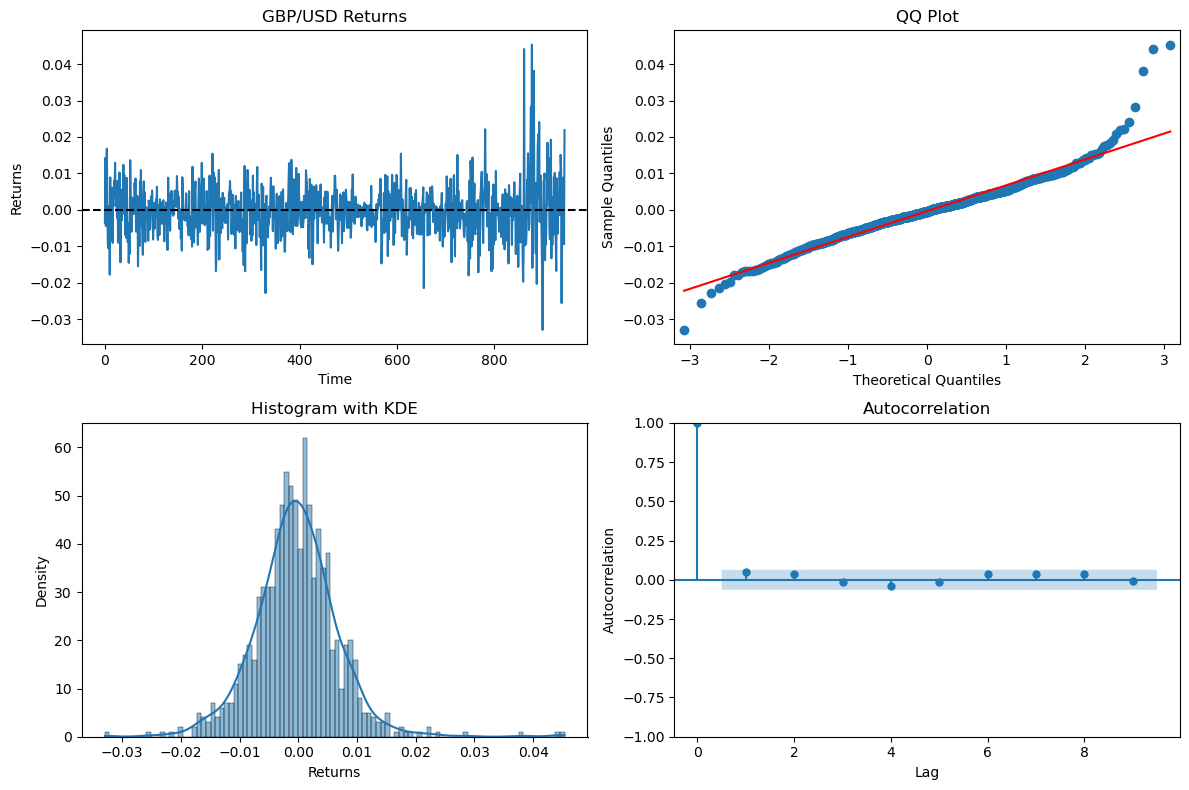

In [4]:
# Create the figure and axes for the subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the data
sns.lineplot(data=df, x=df.index, y='GBPUSD', ax=axs[0][0])
axs[0][0].axhline(y=0, color='black', linestyle='--')
axs[0][0].set_xlabel('Time')
axs[0][0].set_ylabel('Returns')
axs[0][0].set_title('GBP/USD Returns')

# Plot the QQ plot
sm.qqplot(df['GBPUSD'], line='s', ax=axs[0][1])
axs[0][1].set_xlabel('Theoretical Quantiles')
axs[0][1].set_ylabel('Sample Quantiles')
axs[0][1].set_title('QQ Plot')

# Plot the histogram with kernel density
sns.histplot(data=df, x='GBPUSD', bins=100, kde=True, ax=axs[1][0])
axs[1][0].set_xlabel('Returns')
axs[1][0].set_ylabel('Density')
axs[1][0].set_title('Histogram with KDE')

# Plot the autocorrelation
sm.graphics.tsa.plot_acf(df['GBPUSD'], ax=axs[1][1], lags=9)
axs[1][1].set_xlabel('Lag')
axs[1][1].set_ylabel('Autocorrelation')
axs[1][1].set_title('Autocorrelation')

# Adjust the spacing between the subplots
fig.tight_layout()

# Display the plot
plt.show()

#### Question B

In [5]:
# Create column xt - log returns
df['xt'] = np.log((df['GBPUSD'] - df['GBPUSD'].mean()) ** 2)
df.head(10)

,GBPUSD,xt
0,-0.003555,-11.487826
1,0.014254,-8.452482
2,-0.004439,-11.000233
3,0.010257,-9.091992
4,0.016776,-8.133977
5,0.003690,-11.021466
6,-0.009410,-9.408437
7,-0.010519,-9.177468
8,-0.002957,-11.901804
9,0.001076,-13.101226


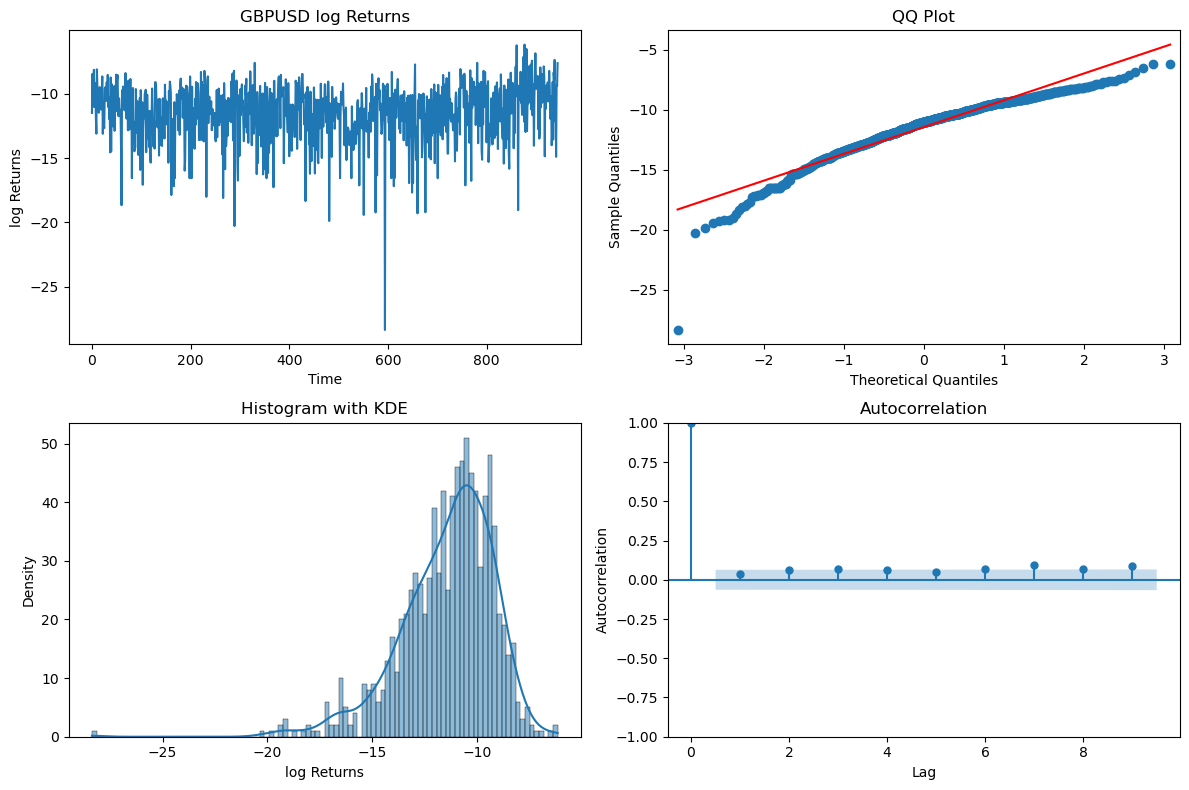

In [6]:
# Create plots of log returns
# Create the figure and axes for the subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the data
sns.lineplot(data=df, x=df.index, y='xt', ax=axs[0][0])
axs[0][0].set_xlabel('Time')
axs[0][0].set_ylabel('log Returns')
axs[0][0].set_title('GBPUSD log Returns')

# Plot the QQ plot
sm.qqplot(df['xt'], line='s', ax=axs[0][1])
axs[0][1].set_xlabel('Theoretical Quantiles')
axs[0][1].set_ylabel('Sample Quantiles')
axs[0][1].set_title('QQ Plot')

# Plot the histogram with kernel density
sns.histplot(data=df, x='xt', bins=100, kde=True, ax=axs[1][0])
axs[1][0].set_xlabel('log Returns')
axs[1][0].set_ylabel('Density')
axs[1][0].set_title('Histogram with KDE')

# Plot the autocorrelation
sm.graphics.tsa.plot_acf(df['xt'], ax=axs[1][1], lags=9)
axs[1][1].set_xlabel('Lag')
axs[1][1].set_ylabel('Autocorrelation')
axs[1][1].set_title('Autocorrelation')

# Adjust the spacing between the subplots
fig.tight_layout()

# Display the plot
plt.show()

#### Question C

In [7]:
# Define the log-likelihood function
def loglik(params, yt):
    Qt = params[0]
    ct = params[1]
    Tt = params[2]
    Ht = (np.pi**2)/2
    dt = -1.27
    Zt = 1
    Rt = 1
    
    a0 = ct/(1-Tt) #unconditional mean
    P0 = Qt/(1-Tt**2) #unconditional variance
    n = len(yt)
    ll = np.zeros(n) #vector to store marginal log likelihoods

    for t in range(n):
        if t == 0:
            at = a0
            Pt = P0
   
        else:
            at = Tt*at_prev + Kt_prev*vt_prev + ct
            Pt = Tt*Pt*Tt + Rt*Qt*Rt - Kt_prev*Ft*Kt_prev 

        vt = yt[t] - Zt*at - dt
        Ft = Zt*Pt*Zt + Ht
        Kt = Tt*Pt*Zt / Ft
        at_prev, Kt_prev, vt_prev = at, Kt, vt
    
        ll[t] = -0.5 * (np.log(Ft) + (vt**2 / Ft))
    
    logl = -(n/2) * np.log(2 * np.pi) + ll[0:n].sum() # = n*constant + summation of ll[t]
        
    return -logl / n #average log likelihood

In [8]:
# Find initial values
yt = df['xt'].copy()
var_yt = np.var(yt, ddof=1)

# Initial phi
phi_initial = 0.95

# Initial omega
omega_initial = (1-phi_initial)*(np.mean(yt) + 1.27)

# Initial sigma eta
sigN_initial = (1-(phi_initial**2))*(var_yt - ((np.pi**2)/2))

print(f"Initial phi: {phi_initial}")
print(f"Initial omega: {omega_initial}")
print(f"Initial sigma_eta: {sigN_initial}")


Initial phi: 0.95
Initial omega: -0.5086934271126993
Initial sigma_eta: 0.007446382236748508


In [9]:
#Run the optimization
#Set initial parameter values
params0 = [sigN_initial, omega_initial, phi_initial]

# Set bounds for the parameters
# The Bounds class takes two arrays that specify the lower and upper bounds for each parameter, respectively. 
bounds = Bounds([1e-10, -np.inf, 0], [np.inf, np.inf, 1 - 1e-10])

# Estimate the parameters using maximum likelihood
MLE = minimize(loglik, params0, args=(yt,), method='L-BFGS-B', bounds=bounds)

MLE

      fun: 2.2060842103781395
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.19483037,  0.01939795, -0.09630998])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 124
      nit: 18
     njev: 31
   status: 0
  success: True
        x: array([ 0.01793281, -0.14894576,  0.98516254])

#### Question D

In [10]:
# Kalman Filter Filter and Kalman Smoother function
def KFS_SV(params, yt):
    # Setting parameters
    Qt = params[0]
    ct = params[1]
    Tt = params[2]
    Ht = (np.pi**2)/2
    dt = -1.27 
    Zt = 1
    Rt = 1
    
    ## Kalman Filter
    # Setting starting values for a1 and P1
    a1 = ct/(1-Tt) # Unconditional mean
    P1 = Qt/(1-Tt**2) # Unconditional variance
    
    # For loop to get Kalman Filter estimates
    n = len(yt)
    KF = np.zeros((n, 5)) # Matrix to store Kalman Filter estimates
    
    for t in range(n):
        if t == 0:
            at = a1
            Pt = P1
   
        else:
            at = Tt*at_prev + Kt_prev*vt_prev + ct
            Pt = Tt*Pt*Tt + Rt*Qt*Rt - Kt_prev*Ft*Kt_prev 

        vt = yt[t] - Zt*at - dt
        Ft = Zt*Pt*Zt + Ht
        Kt = Tt*Pt*Zt / Ft
        
        # Storing each recursion in the KF matrix
        KF[t,:] = [at, Pt, vt, Ft, Kt]
        
        # Setting at, kt, vt to _prev to use them in the next iteration
        at_prev, Kt_prev, vt_prev = at, Kt, vt
    
    ## Kalman Smoother
    # Getting filter estimates out of KF matrix for easier use in smoothing for loop
    at = KF[:,0]
    Pt = KF[:,1]
    vt = KF[:,2]
    Ft = KF[:,3]
    Kt = KF[:,4]
    
    # Vectors to store Kalman Smoother estimates
    rt = np.zeros(n)
    Nt = np.zeros(n)
    Lt = np.zeros(n)
    Ahat = np.zeros(n) # smoothed estimates for ht_tilde
    Vt = np.zeros(n)
    
    # Backwards recursion
    rt[n-1] = 0
    Nt[n-1] = 0
    
   # Vectors to store Kalman Smoother estimates
    rt = np.zeros(n)
    Nt = np.zeros(n)
    Lt = np.zeros(n)
    Ahat = np.zeros(n) # smoothed estimates for ht_tilde
    Vt = np.zeros(n)
    
    for t in range(n-1, 0, -1): # iterate backwards from second-to-last to first row
        Lt[t] = Tt - Kt[t]*Zt
        rt[t-1] = Zt/Ft[t]*vt[t] + Lt[t]*rt[t]
        Nt[t-1] = Zt/Ft[t]*Zt + Lt[t]*Nt[t]*Lt[t]
        Ahat[t] = at[t] + Pt[t]*rt[t-1]
        Vt[t] = Pt[t] - Pt[t]*Nt[t-1]*Pt[t]
    
    # Getting values for Lt, Ahat, Vt in first row manually for simplicity 
    Lt[0] = Tt - Kt[0]*Zt
    rt_0 = Zt/Ft[0]*vt[0] + Lt[0]*rt[0]
    Nt_0 = Zt/Ft[0]*Zt + Lt[0]*Nt[0]*Lt[0]
    Ahat[0] = at[0] + Pt[0]*rt_0 # smoothed state for 
    Vt[0] = Pt[0] - Pt[0]*Nt_0*Pt[0] 
    
    # Creating dataframe with relevant KF and KS estimates
    KFS = pd.DataFrame({'yt': yt, 'at': at, 'Ahat': Ahat, 'rt': rt, 'Nt': Nt})
    
    return KFS

In [11]:
parameters = MLE.x # Getting parameters from MLE 
yt = df['xt'].copy()
KFS_SVmodel = KFS_SV(parameters, yt) # Estimating KFS estimates
dt = -1.27
KFS_SVmodel['signal'] = KFS_SVmodel['Ahat'] + dt
KFS_SVmodel

,yt,at,Ahat,rt,Nt,signal
0,-11.487826,-10.038493,-9.271840,1.472784,1.096650,-10.541840
1,-8.452482,-10.057896,-9.256804,1.068289,1.160944,-10.526804
2,-11.000233,-9.776372,-9.249245,1.183315,1.217678,-10.519245
3,-9.091992,-9.776129,-9.239735,0.909515,1.267743,-10.509735
4,-8.133977,-9.618061,-9.235276,0.435450,1.311921,-10.505276
...,...,...,...,...,...,...
940,-10.745749,-9.244889,-9.229717,0.114637,0.646966,-10.499717
941,-14.902131,-9.267234,-9.239662,1.019869,0.514194,-10.509662
942,-9.362474,-9.478520,-9.233225,0.800584,0.363733,-10.503225
943,-9.397527,-9.423370,-9.230817,0.585701,0.193225,-10.500817


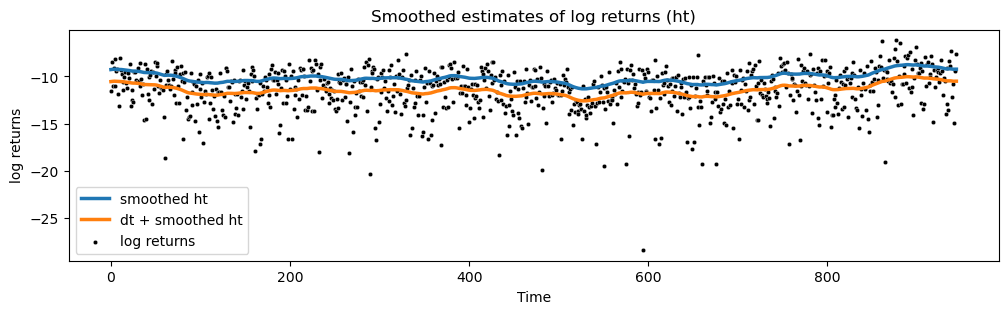

In [12]:
# Create plots
# Plot smoothed values of ht
fig, ax = plt.subplots(figsize=(12,3))
sns.scatterplot(data=KFS_SVmodel, x=KFS_SVmodel.index, y='yt', color = 'black', s=10, label='log returns')
sns.lineplot(data=KFS_SVmodel, x=KFS_SVmodel.index, y='Ahat', linewidth=2.5, label='smoothed ht')
sns.lineplot(data=KFS_SVmodel, x=KFS_SVmodel.index, y='signal', linewidth=2.5, label='dt + smoothed ht')
plt.xlabel('Time')
plt.ylabel('log returns')
plt.title('Smoothed estimates of log returns (ht)')
plt.legend(loc='best')
plt.show()

In [13]:
KFS_SVmodel

,yt,at,Ahat,rt,Nt,signal
0,-11.487826,-10.038493,-9.271840,1.472784,1.096650,-10.541840
1,-8.452482,-10.057896,-9.256804,1.068289,1.160944,-10.526804
2,-11.000233,-9.776372,-9.249245,1.183315,1.217678,-10.519245
3,-9.091992,-9.776129,-9.239735,0.909515,1.267743,-10.509735
4,-8.133977,-9.618061,-9.235276,0.435450,1.311921,-10.505276
...,...,...,...,...,...,...
940,-10.745749,-9.244889,-9.229717,0.114637,0.646966,-10.499717
941,-14.902131,-9.267234,-9.239662,1.019869,0.514194,-10.509662
942,-9.362474,-9.478520,-9.233225,0.800584,0.363733,-10.503225
943,-9.397527,-9.423370,-9.230817,0.585701,0.193225,-10.500817


In [14]:
# Extracting the Ht:
ksi_GBP = parameters[1] / (1 - parameters[2])
# to obtain Ht we perform:
KFS_SVmodel['Ht'] = KFS_SVmodel['Ahat'].apply(lambda x: x - ksi_GBP)

In [15]:
KFS_SVmodel['EH_yt'] = KFS_SVmodel['at'] - ksi_GBP
KFS_SVmodel['EH_yn'] = KFS_SVmodel['Ahat'] - ksi_GBP

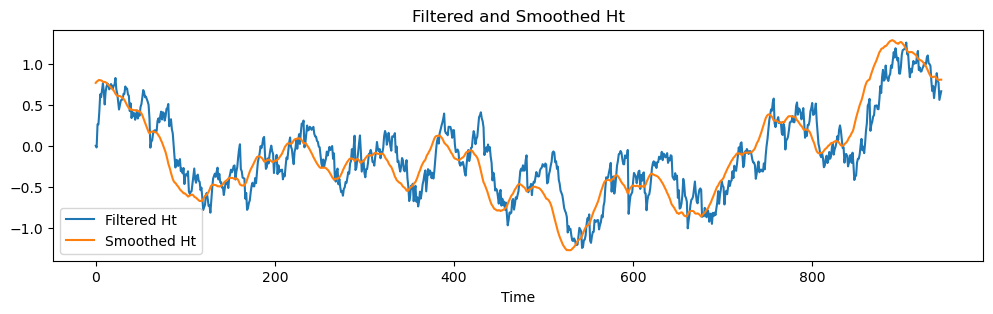

In [16]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(KFS_SVmodel['EH_yt'], label = 'Filtered Ht')
plt.plot(KFS_SVmodel['EH_yn'], label='Smoothed Ht')
plt.xlabel('Time')
plt.title('Filtered and Smoothed Ht')
plt.legend(loc='best')
plt.show()

# Question E

In [17]:
# Download historical data for S&P500 index
tickerSymbol = '^GSPC'
tickerData = yf.Ticker(tickerSymbol)
sp500 = tickerData.history(start='2016-01-01', end='2021-01-01')

# Calculate daily returns
sp500["log"] = np.log(sp500["Close"])
sp500['Adj Close'] = sp500['log'].diff()
#sp500['daily_returns'] = sp500['Close'].pct_change()

# Print first 5 rows of the resulting dataframe
#sp500['returns']
print(sp500.head())

                                  Open         High          Low        Close  \
Date                                                                            
2016-01-04 00:00:00-05:00  2038.199951  2038.199951  1989.680054  2012.660034   
2016-01-05 00:00:00-05:00  2013.780029  2021.939941  2004.170044  2016.709961   
2016-01-06 00:00:00-05:00  2011.709961  2011.709961  1979.050049  1990.260010   
2016-01-07 00:00:00-05:00  1985.319946  1985.319946  1938.829956  1943.089966   
2016-01-08 00:00:00-05:00  1945.969971  1960.400024  1918.459961  1922.030029   

                               Volume  Dividends  Stock Splits       log  \
Date                                                                       
2016-01-04 00:00:00-05:00  4304880000        0.0           0.0  7.607213   
2016-01-05 00:00:00-05:00  3706620000        0.0           0.0  7.609223   
2016-01-06 00:00:00-05:00  4336660000        0.0           0.0  7.596021   
2016-01-07 00:00:00-05:00  5076590000        0.0    

In [18]:
# Create a DF for the adjusted close and set the date column as first, index being an index
df_sp500 = pd.DataFrame(sp500['Adj Close']).reset_index()
# Converted the daily returns to log - returns:
df_sp500['xt'] = np.log((df_sp500['Adj Close'] - df_sp500['Adj Close'].mean()) ** 2)
# Remove first row with NA values
df_sp500.dropna(inplace=True)

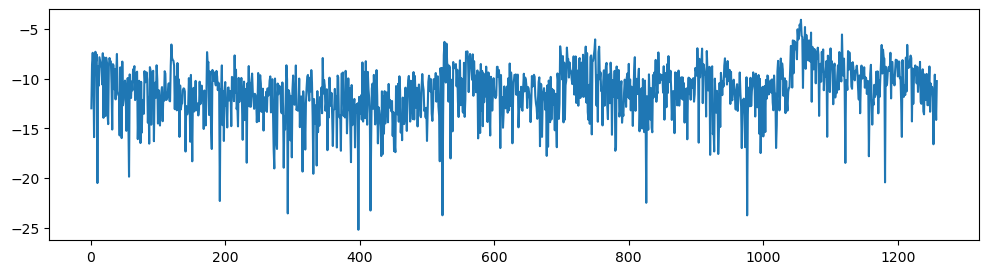

In [19]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(df_sp500['xt'])
# plt.plot(Realized)
plt.show()

In [20]:
# Compute SP500 standard moments
mean_sp500 = df_sp500['Adj Close'].mean()
mode_sp500 = df_sp500['Adj Close'].mode()[0]
median_sp500 = df_sp500['Adj Close'].median()
variance_sp500 = df_sp500['Adj Close'].var(ddof=1)
skewness_sp500 = df_sp500['Adj Close'].skew()
kurtosis_sp500 = df_sp500['Adj Close'].kurtosis()

# Print the results
print(f"Mean: {mean_sp500}")
print(f"Mode: {mode_sp500}")
print(f"Median: {median_sp500}")
print(f"Variance: {variance_sp500}")
print(f"Skewness: {skewness_sp500}")
print(f"Kurtosis: {kurtosis_sp500}")

Mean: 0.0004959586398898719
Mode: -0.12765219747281709
Median: 0.0007112741534180955
Variance: 0.0001482854905051182
Skewness: -1.1391346088194176
Kurtosis: 22.104576261563547


In [21]:
def return_plots(df, name, title):
    # Create the figure and axes for the subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # Plot the data
    sns.lineplot(data=df, x=df['Date'], y=name.strip(), ax=axs[0][0])
    axs[0][0].set_xlabel('Time')
    axs[0][0].set_ylabel('Returns')
    axs[0][0].set_title('{} Returns'.format(name))

    # Plot the QQ plot
    sm.qqplot(df[name], line='s', ax=axs[0][1])
    axs[0][1].set_xlabel('Theoretical Quantiles')
    axs[0][1].set_ylabel('Sample Quantiles')
    axs[0][1].set_title('QQ Plot')

    # Plot the histogram with kernel density
    sns.histplot(data=df, x=name.strip(), bins=100, kde=True, ax=axs[1][0])
    axs[1][0].set_xlabel('Returns')
    axs[1][0].set_ylabel('Density')
    axs[1][0].set_title('Histogram with KDE')

    # Plot the autocorrelation
    sm.graphics.tsa.plot_acf(df[name], ax=axs[1][1], lags=10)
    axs[1][1].set_xlabel('Lag')
    axs[1][1].set_ylabel('Autocorrelation')
    axs[1][1].set_title('Autocorrelation')

    # Adjust the spacing between the subplots
    fig.tight_layout()
    
     # Add a common title for all the subplots
    fig.suptitle(title)
    
    # Save the figure with title as the file name
    fig.savefig('{}.png'.format(title))
    
    return plt.show()

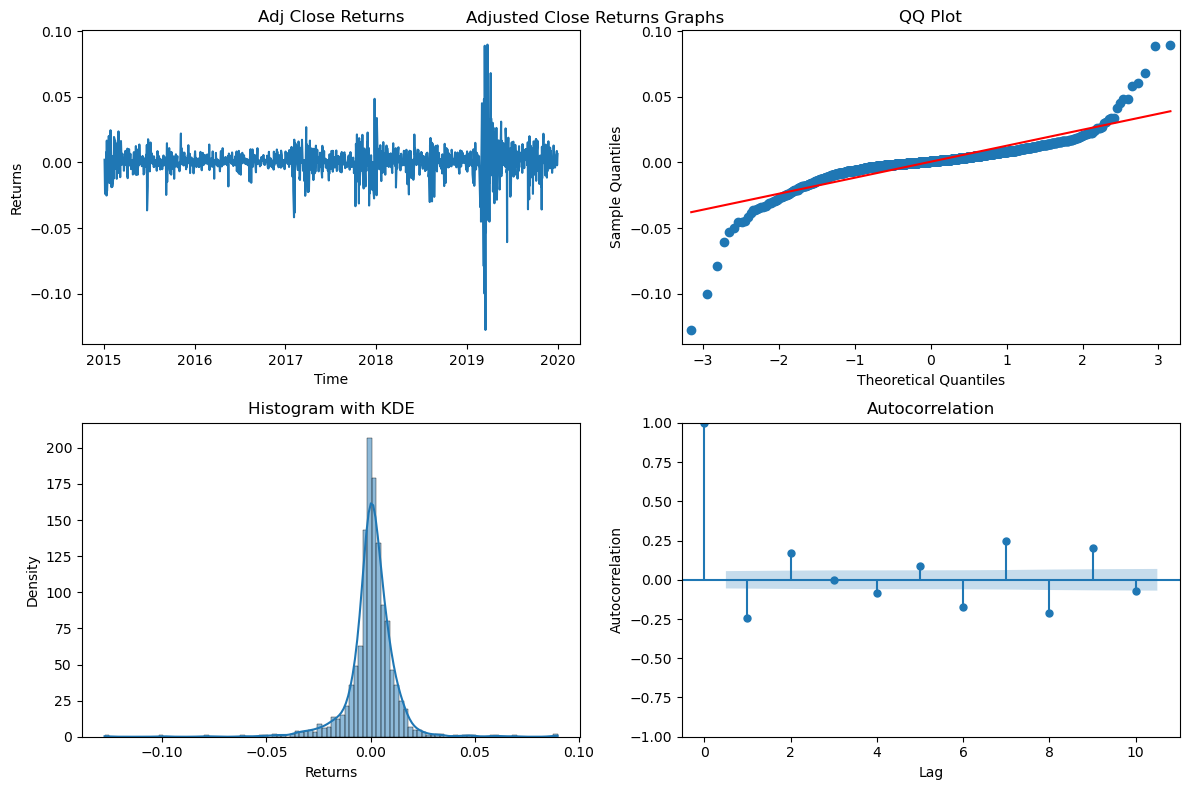

In [22]:
# plot the Adjusted Close
return_plots(df_sp500, 'Adj Close', 'Adjusted Close Returns Graphs')

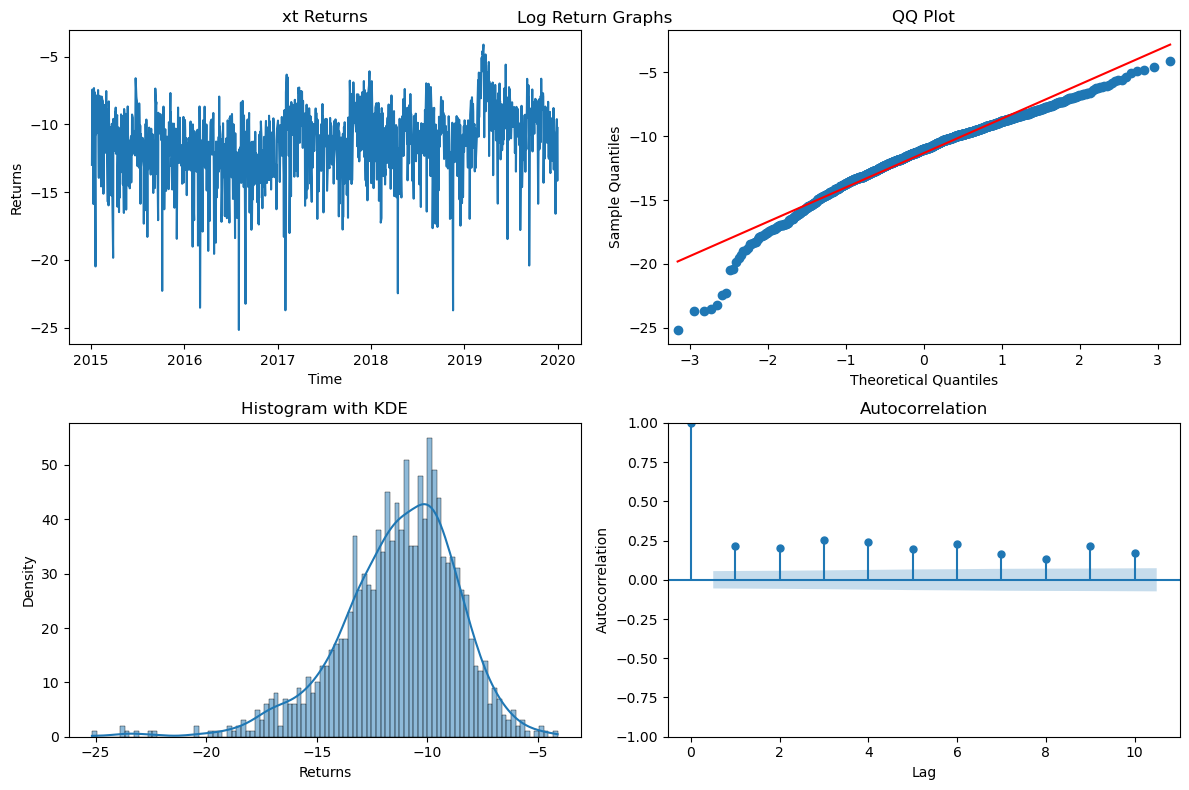

In [23]:
# Plot the log returns of the Index:

return_plots(df_sp500, 'xt', 'Log Return Graphs')

In [24]:
# Find initial values for the S&P500:
yt_sp = df_sp500['xt'].copy().to_numpy()
var_yt_sp = np.var(yt_sp, ddof=1)

# Initial phi
phi_initial_sp = 0.95

# Initial omega
omega_initial_sp = (1-phi_initial_sp)*(np.mean(yt_sp) + 1.27)

# Initial sigma eta
sigN_initial_sp = (1-(phi_initial_sp**2))*(var_yt_sp - ((np.pi**2)/2))

print(f"Initial phi: {phi_initial_sp}")
print(f"Initial omega: {omega_initial_sp}")
print(f"Initial sigma_eta: {sigN_initial_sp}")

Initial phi: 0.95
Initial omega: -0.5021557281903901
Initial sigma_eta: 0.22435047498565827


In [25]:
#Run the optimization for the S&P500
#Set initial parameter values
params_sp = [sigN_initial_sp, omega_initial_sp, phi_initial_sp]

# Set bounds for the parameters
# The Bounds class takes two arrays that specify the lower and upper bounds for each parameter, respectively. 
bounds_sp = Bounds([1e-10, -np.inf, 0], [np.inf, np.inf, 1 - 1e-10])

# Estimate the parameters using maximum likelihood
MLE_sp = minimize(loglik, params_sp, args=(yt_sp,), method='L-BFGS-B', bounds=bounds_sp)

MLE_sp

      fun: 2.3279012629994478
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.10942375e-05,  1.30206956e-04, -1.32911459e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 13
     njev: 20
   status: 0
  success: True
        x: array([ 0.09266185, -0.26984638,  0.9730909 ])

In [26]:
# Optimized parameters for the SP500 case:
params_sp_opt = MLE_sp.x

In [27]:
# Performing the KFS to extract the necessary variables in a new DF:
KFS_SVmodel_sp500 = KFS_SV(params_sp_opt, yt_sp)
KFS_SVmodel_sp500['signal'] = KFS_SVmodel_sp500['Ahat'] -1.27 

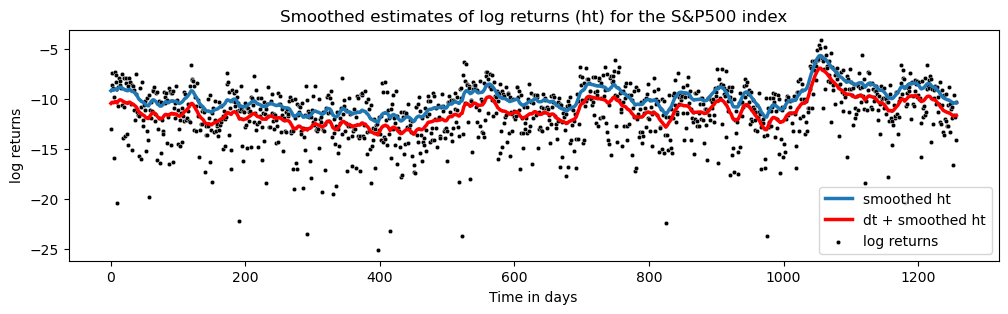

In [28]:
# Create plots
# Plot smoothed values of ht
fig, ax = plt.subplots(figsize=(12,3))
sns.scatterplot(data=KFS_SVmodel_sp500, x=KFS_SVmodel_sp500.index, y='yt', color = 'black', s=10, label='log returns')
sns.lineplot(data=KFS_SVmodel_sp500, x=KFS_SVmodel_sp500.index, y='Ahat', linewidth=2.5, label='smoothed ht')
sns.lineplot(data=KFS_SVmodel_sp500, x=KFS_SVmodel_sp500.index, y='signal',color = 'red', linewidth=2.5, label='dt + smoothed ht')
plt.xlabel('Time in days')
plt.ylabel('log returns')
plt.title('Smoothed estimates of log returns (ht) for the S&P500 index')
plt.legend(loc='best')
plt.savefig('Smoothed estimates of log returns (ht) for the S&P500 index.png')
plt.show()

In [29]:
# Extracting the Ht:
ksi = params_sp_opt[1] / (1 - params_sp_opt[2])
ksi # and the disturbance term here is fixed

-10.028070428911784

In [30]:
# to obtain Ht we perform:
KFS_SVmodel_sp500['Ht'] = KFS_SVmodel_sp500['Ahat'].apply(lambda x: x - ksi)

In [31]:
KFS_SVmodel_sp500['Ht_yt'] = KFS_SVmodel_sp500['at'] - ksi
KFS_SVmodel_sp500['Ht_yn'] = KFS_SVmodel_sp500['Ahat'] - ksi

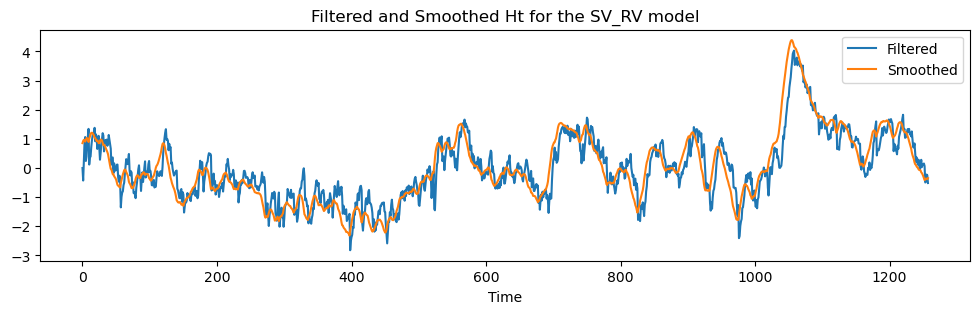

In [32]:
# plotting 
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(KFS_SVmodel_sp500['Ht_yt'], label='Filtered')
plt.plot(KFS_SVmodel_sp500['Ht_yn'], label='Smoothed')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title('Filtered and Smoothed Ht for the SV_RV model')
plt.savefig('Filtered and Smoothed Ht for the SV_RV model.png')
plt.show()

## Applying the Realized Volatility method using the Augmentation method:

In [33]:
df2 = pd.read_csv('./realized_volatility.csv')

In [34]:
# We select the RV measure - in this case could be rv10
# We filter the data only to the one that is relevant to us
# As a ticker we select the GSPTSE, which corresponds to the S&P 500 index and we select the same time period as in the previous exercise
df_rv = df2.loc[(df2['date'] > '2016-01-01 00:00:00+00:00') & (df2['date'] < '2021-01-01 00:00:00+00:00') & (df2['Symbol'] == '.GSPTSE'), ['date','rv10']]
df_rv['date'] = df_rv['date'].str.slice(stop=10)

In [35]:
df_rv['Date'] = pd.to_datetime(df_rv['date'])

In [36]:
df_rv.reset_index(inplace=True)
df_rv.drop(['index','date'], axis=1, inplace=True)

In [37]:
# adjust the df_sp500 in the proper format:
df_rv['Date'] = pd.to_datetime(df_rv['Date']).dt.tz_localize('America/New_York')

#### Merge the two dataframes:

In [38]:
merged_df = pd.merge(df_sp500, df_rv, on='Date', how='left')

In [39]:
Realized_DF = merged_df.dropna()

In [40]:
Realized_DF.reset_index(inplace=True)
Realized_DF.drop(['index'], axis=1, inplace=True)

<ipython-input-40-cbb370c8b1c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Realized_DF.drop(['index'], axis=1, inplace=True)


In [41]:
Realized_DF['logrv10'] = Realized_DF['rv10'].apply(lambda x: np.log(x) - 1.27)

<ipython-input-41-d6fb9bd49c40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Realized_DF['logrv10'] = Realized_DF['rv10'].apply(lambda x: np.log(x) - 1.27)


In [42]:
Realized_DF.head()

,Date,Adj Close,xt,rv10,logrv10
0,2016-01-05 00:00:00-05:00,0.002010,-12.985676,0.000053,-11.114922
1,2016-01-06 00:00:00-05:00,-0.013202,-8.580993,0.000058,-11.020446
2,2016-01-07 00:00:00-05:00,-0.023986,-7.419653,0.000135,-10.178877
3,2016-01-08 00:00:00-05:00,-0.010898,-8.949425,0.000082,-10.675828
4,2016-01-11 00:00:00-05:00,0.000853,-15.875832,0.000065,-10.911113


## The steps to perform the Augmented 

#### 1. Run the KF as before and store the prediction errors vt* and variances and Ft

In [43]:
# Kalman Filter 
def KF_RV(yt):
    # Setting parameters
    Qt = params_sp_opt[0] # this is the optimized sigma
    ct = params_sp_opt[1] # the optimized omega
    Tt = params_sp_opt[2] # the optimized fi
    Ht = (np.pi**2)/2
    dt = -1.27
    Zt = 1
    Rt = 1
    
    ## Kalman Filter
    # Setting starting values for a1 and P1
    a1 = ct/(1-Tt) # Unconditional mean
    P1 = Qt/(1-Tt**2) # Unconditional variance
    
    # For loop to get Kalman Filter estimates
    n = len(yt)
    KF = np.zeros((n, 5)) # Matrix to store Kalman Filter estimates
    
    for t in range(n):
        if t == 0:
            at = a1
            Pt = P1
   
        else:
            at = Tt*at_prev + Kt_prev*vt_prev + ct
            Pt = Tt*Pt*Tt + Rt*Qt*Rt - Kt_prev*Ft*Kt_prev 
        # vt is vt* here:
        vt = yt[t] - Zt*at - dt
        Ft = Zt*Pt*Zt + Ht
        Kt = Tt*Pt*Zt / Ft
        
        # Storing each recursion in the KF matrix
        KF[t,:] = [at, Pt, vt, Ft, Kt]
        
        # Setting at, kt, vt to _prev to use them in the next iteration
        at_prev, Kt_prev, vt_prev = at, Kt, vt    
    return KF

In [44]:
KF_RV(Realized_DF['xt'])

array([[-10.02807043,   1.74523798,  -1.68760554,   6.68004018,
          0.25423128],
       [-10.45711255,   1.3134833 ,   3.14611943,   6.2482855 ,
          0.2045583 ],
       [ -9.80200258,   1.07495306,   3.65234996,   6.00975526,
          0.17405485],
       ...,
       [-10.49032996,   0.59682299,  -0.04963946,   5.53162519,
          0.10498958],
       [-10.48310259,   0.59682299,  -2.39998042,   5.53162519,
          0.10498958],
       [-10.72283103,   0.59682299,   1.73475203,   5.53162519,
          0.10498958]])

In [45]:
KF_1 = pd.DataFrame(KF_RV(Realized_DF['xt']), columns=['at', 'Pt', 'vt*', 'Ft', 'Kt'])

In [46]:
KF_1.head()

,at,Pt,vt*,Ft,Kt
0,-10.028070,1.745238,-1.687606,6.680040,0.254231
1,-10.457113,1.313483,3.146119,6.248285,0.204558
2,-9.802003,1.074953,3.652350,6.009755,0.174055
3,-9.172377,0.928475,1.492951,5.863277,0.154093
4,-8.965349,0.832619,-5.640483,5.767421,0.140481


#### 2. Run the KF using log(RV_t) - 1.27 as observations and store prediction errors xt*

In [47]:
KF_2 = pd.DataFrame(KF_RV(Realized_DF['logrv10']), columns=['at', 'Pt', 'xt*', 'Ft', 'Kt'])

In [48]:
KF_2.head()

,at,Pt,xt*,Ft,Kt
0,-10.028070,1.745238,0.183149,6.680040,0.254231
1,-9.981508,1.313483,0.231062,6.248285,0.204558
2,-9.935496,1.074953,1.026618,6.009755,0.174055
3,-9.759299,0.928475,0.353471,5.863277,0.154093
4,-9.712064,0.832619,0.070950,5.767421,0.140481


In [49]:
# KF_3 includes all necessary variables for estimating the GLS:
KF_3 = KF_2.copy()
KF_3['vt*'] = KF_1['vt*']
KF_3.head(1)

,at,Pt,xt*,Ft,Kt,vt*
0,-10.02807,1.745238,0.183149,6.68004,0.254231,-1.687606


#### 3. Apply the GLM formulas:

#### GLS for Beta_hat

In [50]:
# Beta_hat (mean)
# list 1 is the first part of the equation:
list_1 = [((KF_3['xt*']**2) / KF_3['Ft'])] 
# list_2 is the second part of the equation
list_2 = [(KF_3['xt*'] * KF_3['vt*'])/KF_3['Ft']]
# we get the sums of both lists and devide list 2 by list 1
Beta_hat = np.sum(list_2)/np.sum(list_1)

In [51]:
Beta_hat

0.7527935578856801

#### GLS for Beta_var

In [52]:
# the equation is the same as in the list_1 from the previous part
Beta_var = 1 / np.sum(list_1)

### Run the KFS on the Augmented Model  

In [53]:
#### we need to run the KFS to extract the "augmented" xt and compare it with the one from the basic model

### Augmented variable:

In [54]:
# Augmented variable:
# we put the observation as xt - Beta * logRV to find the augmented ht
Realized_DF['augmented_x_t'] = Realized_DF['xt'] - Beta_hat * Realized_DF['logrv10']

<ipython-input-54-da9c67774d0a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Realized_DF['augmented_x_t'] = Realized_DF['xt'] - Beta_hat * Realized_DF['logrv10']


In [55]:
# Kalman Filter applied to the augmented model: ####add here####
def KFS_augmented(yt):
    # Setting parameters
    Qt = params_sp_opt[0] # this is the optimized sigma
    ct = params_sp_opt[1] # the optimized omega
    Tt = params_sp_opt[2] # the optimized fi
    Ht = (np.pi**2)/2
    dt = -1.27
    Zt = 1
    Rt = 1
    
    ## Kalman Filter
    # Setting starting values for a1 and P1
    a1 = ct/(1-Tt) # Unconditional mean
    P1 = Qt/(1-Tt**2) # Unconditional variance
    
    # For loop to get Kalman Filter estimates
    n = len(yt)
    KF = np.zeros((n, 5)) # Matrix to store Kalman Filter estimates
    
    for t in range(n):
        if t == 0:
            at = a1
            Pt = P1
   
        else:
            at = Tt*at_prev + Kt_prev*vt_prev + ct
            Pt = Tt*Pt*Tt + Rt*Qt*Rt - Kt_prev*Ft*Kt_prev 

        vt = yt[t] - Zt*at - dt
        Ft = Zt*Pt*Zt + Ht
        Kt = Tt*Pt*Zt / Ft
        
        # Storing each recursion in the KF matrix
        KF[t,:] = [at, Pt, vt, Ft, Kt]
        
        # Setting at, kt, vt to _prev to use them in the next iteration
        at_prev, Kt_prev, vt_prev = at, Kt, vt
        
        ## Kalman Smoother
    # Getting filter estimates out of KF matrix for easier use in smoothing for loop
    at = KF[:,0]
    Pt = KF[:,1]
    vt = KF[:,2]
    Ft = KF[:,3]
    Kt = KF[:,4]
    
    # Vectors to store Kalman Smoother estimates
    rt = np.zeros(n)
    Nt = np.zeros(n)
    Lt = np.zeros(n)
    Ahat = np.zeros(n) # smoothed estimates for ht_tilde
    Vt = np.zeros(n)
    
    # Backwards recursion
    rt[n-1] = 0
    Nt[n-1] = 0
    
   # Vectors to store Kalman Smoother estimates
    rt = np.zeros(n)
    Nt = np.zeros(n)
    Lt = np.zeros(n)
    Ahat = np.zeros(n) # smoothed estimates for ht_tilde
    Vt = np.zeros(n)
    
    for t in range(n-1, 0, -1): # iterate backwards from second-to-last to first row
        Lt[t] = Tt - Kt[t]*Zt
        rt[t-1] = Zt/Ft[t]*vt[t] + Lt[t]*rt[t]
        Nt[t-1] = Zt/Ft[t]*Zt + Lt[t]*Nt[t]*Lt[t]
        Ahat[t] = at[t] + Pt[t]*rt[t-1]
        Vt[t] = Pt[t] - Pt[t]*Nt[t-1]*Pt[t]
    
    # Getting values for Lt, Ahat, Vt in first row manually for simplicity 
    Lt[0] = Tt - Kt[0]*Zt
    rt_0 = Zt/Ft[0]*vt[0] + Lt[0]*rt[0]
    Nt_0 = Zt/Ft[0]*Zt + Lt[0]*Nt[0]*Lt[0]
    Ahat[0] = at[0] + Pt[0]*rt_0 # smoothed state for 
    Vt[0] = Pt[0] - Pt[0]*Nt_0*Pt[0] 
    
    # Creating dataframe with relevant KF and KS estimates
    KFS = pd.DataFrame({'Augmented_h_hat': Ahat})
    
    return KFS

#### E[xt_augmented] = E[ht] + Beta * log(RV) + E[ut]  , E[ut]=0
##### - Beta estimated; logRV is given; Augmented Ht is estiamted through the KFS

In [56]:
Augmented_DF = KFS_augmented(Realized_DF['augmented_x_t'])

In [57]:
Augmented_DF['logRV'] = Realized_DF['logrv10']

In [58]:
Augmented_DF['Augmented_E[Xt]'] = Augmented_DF['Augmented_h_hat'] + Beta_hat * Augmented_DF['logRV']

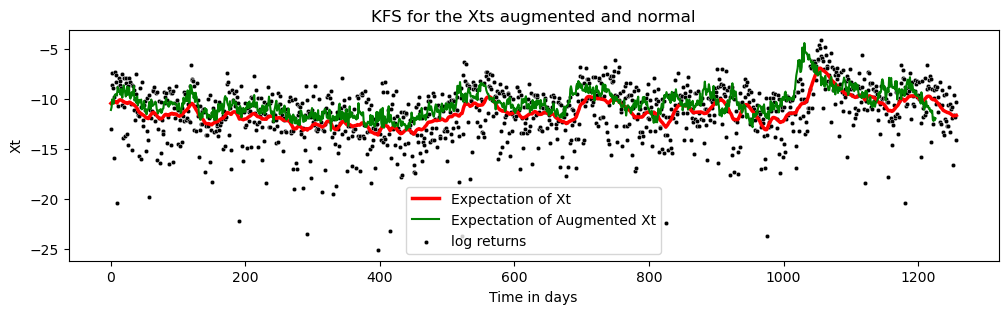

In [59]:
fig, ax = plt.subplots(figsize=(12,3))
sns.lineplot(data=KFS_SVmodel_sp500, x=KFS_SVmodel_sp500.index, y='signal',color = 'red', linewidth=2.5, label='Expectation of Xt')
sns.lineplot(data=Augmented_DF, x=Augmented_DF.index, y='Augmented_E[Xt]', color = 'green', label='Expectation of Augmented Xt')
sns.scatterplot(data=KFS_SVmodel_sp500, x=KFS_SVmodel_sp500.index, y='yt', color = 'black', s=10, label='log returns')
plt.xlabel('Time in days')
plt.ylabel('Xt')
plt.title('KFS for the Xts augmented and normal')
plt.legend(loc='best')
plt.savefig('KFS for the Xts augmented and normal.png')
plt.show()

### Root Mean Sq. Error

In [60]:
# to estimate the performance of the augmented model we use RMSE:
rmse_aug = mean_squared_error(df_sp500['xt'][:1227], Augmented_DF['Augmented_E[Xt]'], squared=False)
rmse_norm = mean_squared_error(df_sp500['xt'][:1227], KFS_SVmodel_sp500['signal'][:1227])
rmse_aug, rmse_norm

(2.7482924648382867, 5.183760826286902)

#### Question F

In [61]:
def bootstrap_filter(y, N, phi, sigma_eta, xi):
    # y: array of observations
    # N: number of particles to use
    # phi: parameter in Ht+1 = phi*Ht + eta
    # sigma_eta: parameter in Ht+1 = phi*Ht + eta
    # xi: parameter in log(sigma^2_t) = xi + Ht
    
    # Get the length of the observation array
    T = len(y)
    
    # Initialize the array for the filtered estimates of Ht
    Ht_hat = np.zeros(T)
    
    # Loop over each observation
    for t in range(T):
        
        if t==0:
            # Initialize an array of particles for the first alpha values
            alpha1 = np.random.normal(loc=0, scale=np.sqrt(sigma_eta / (1 - phi**2)), size=N)
            # Calculate the weights for the first particle
            weights1 = np.exp(-0.5*np.log(2 * np.pi) -0.5*(xi + alpha1) -0.5*((y[t]-mu)**2 / np.exp(xi + alpha1)))
            weights1 = weights1 / np.sum(weights1)
        
            # Calculate the filtered estimate of the first Ht
            Ht_hat[t] = np.sum(weights1 * alpha1)

            # Resample particles for next iteration
            idx = np.random.choice(N, size=N, replace=True, p=weights1)
            alpha = alpha1[idx]
            
        else:
            # Calculate the alpha values for the next time step
            alpha_tilde =  np.random.normal(loc=phi * alpha, scale=np.sqrt(sigma_eta))
        
            # Calculate the weights for each particle
            weights_tilde = np.exp(-0.5*np.log(2 * np.pi) -0.5*(xi + alpha_tilde) -0.5*((y[t]-mu)**2 / np.exp(xi + alpha_tilde)))
            weights = weights_tilde / np.sum(weights_tilde)
        
            # Calculate the filtered estimate of Ht
            Ht_hat[t] = np.sum(weights * alpha_tilde)

            # Resample particles for rest of iterations
            idx = np.random.choice(N, size=N, replace=True, p=weights)
            alpha = alpha_tilde[idx]

    # Return the filtered estimates of Ht
    return Ht_hat

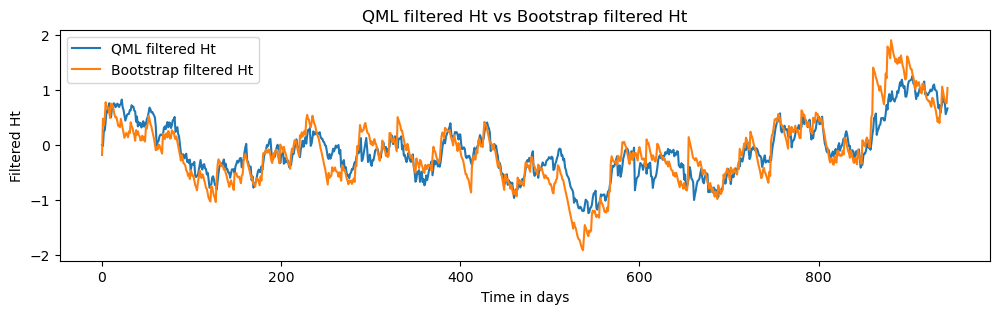

In [62]:
# Plot of QML filtered Ht of question D vs Boostrap filtered Ht of question F
omega = parameters[1]
phi = parameters[2]
xi = omega/(1-phi)
sigma_eta = parameters[0]
yt = df['GBPUSD'].copy().to_numpy()
mu = yt.mean()
y = yt
N = 10000
H_hat = bootstrap_filter(y, N, phi, sigma_eta, xi)

# Creating new dataframe to store QML Ht and Bootstrap Ht
df_QF1 = pd.concat([pd.DataFrame({'H_hat': H_hat}), KFS_SVmodel['EH_yt']], axis=1)

# Plot H_hat
fig, ax = plt.subplots(figsize=(12,3))
sns.lineplot(data=df_QF1, x=df_QF1.index, y='EH_yt', label='QML filtered Ht')
sns.lineplot(data=df_QF1, x=df_QF1.index, y='H_hat', label='Bootstrap filtered Ht')
plt.xlabel('Time in days')
plt.ylabel('Filtered Ht')
plt.title('QML filtered Ht vs Bootstrap filtered Ht')
plt.legend(loc='best')
plt.show()

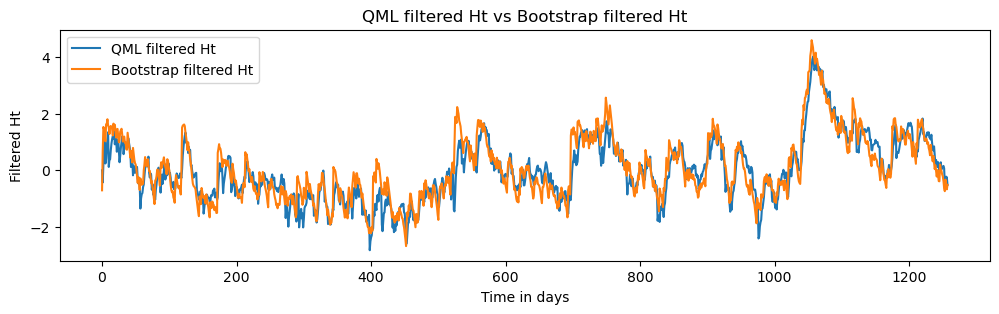

In [63]:
# Plot of QML filtered Ht of question D vs Boostrap filtered Ht of question F
omega = params_sp_opt[1]
phi = params_sp_opt[2]
xi = omega/(1-phi)
sigma_eta = params_sp_opt[0]
yt = df_sp500['Adj Close'].copy().to_numpy()
mu = yt.mean()
y = yt
N = 10000
H_hat = bootstrap_filter(y, N, phi, sigma_eta, xi)

# Creating new dataframe to store QML Ht and Bootstrap Ht
df_QF2 = pd.concat([pd.DataFrame({'H_hat': H_hat}), KFS_SVmodel_sp500['Ht_yt']], axis=1)

# Plot H_hat
fig, ax = plt.subplots(figsize=(12,3))
sns.lineplot(data=df_QF2, x=df_QF2.index, y='Ht_yt', label='QML filtered Ht')
sns.lineplot(data=df_QF2, x=df_QF2.index, y='H_hat', label='Bootstrap filtered Ht')
plt.xlabel('Time in days')
plt.ylabel('Filtered Ht')
plt.title('QML filtered Ht vs Bootstrap filtered Ht')
plt.legend(loc='best')
plt.show()

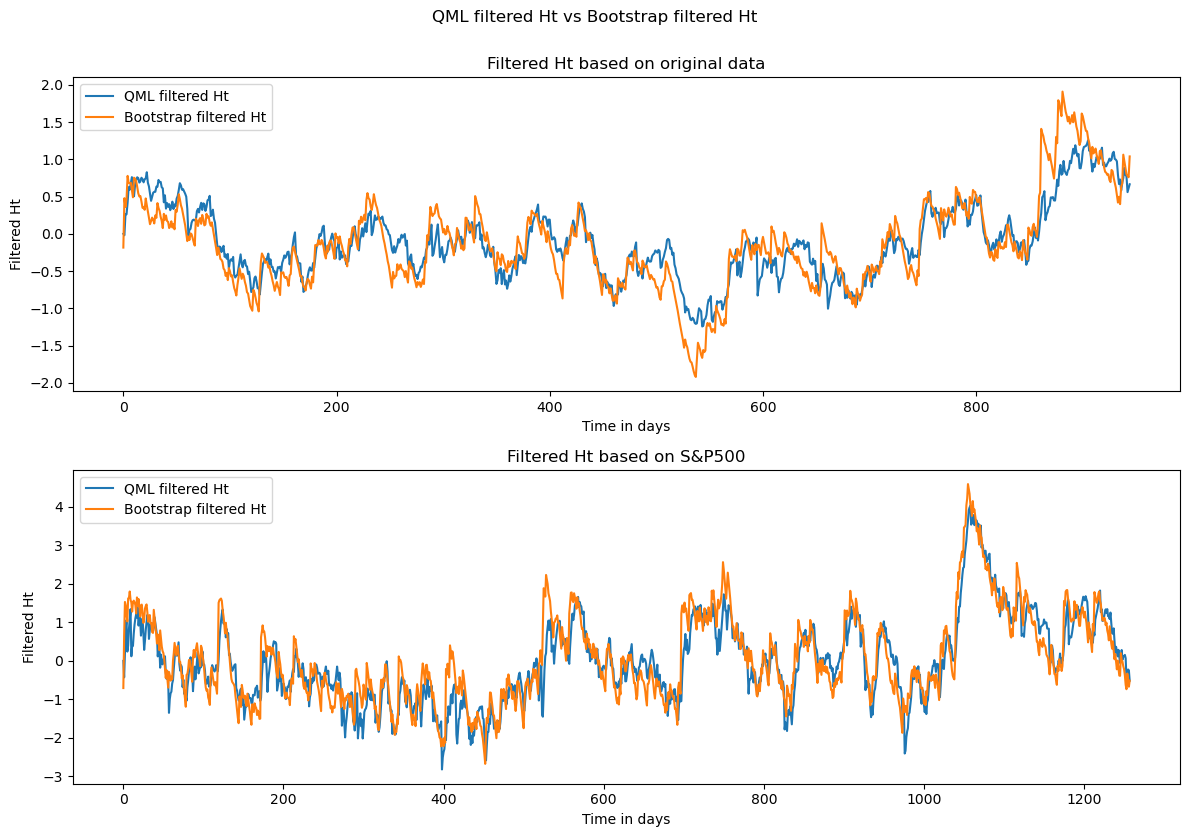

In [64]:
# Create the figure and axes for the subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

sns.lineplot(data=df_QF1, x=df_QF1.index, y='EH_yt', label='QML filtered Ht', ax=axs[0])
sns.lineplot(data=df_QF1, x=df_QF1.index, y='H_hat', label='Bootstrap filtered Ht', ax=axs[0])
axs[0].set_xlabel('Time in days')
axs[0].set_ylabel('Filtered Ht')
axs[0].set_title('Filtered Ht based on original data')
axs[0].legend(loc='upper left')

sns.lineplot(data=df_QF2, x=df_QF2.index, y='Ht_yt', label='QML filtered Ht', ax=axs[1])
sns.lineplot(data=df_QF2, x=df_QF2.index, y='H_hat', label='Bootstrap filtered Ht', ax=axs[1])
axs[1].set_xlabel('Time in days')
axs[1].set_ylabel('Filtered Ht')
axs[1].set_title('Filtered Ht based on S&P500')
axs[1].legend(loc='upper left')

# Adjust the spacing between the subplots
fig.tight_layout()

fig.suptitle('QML filtered Ht vs Bootstrap filtered Ht', y=1.04)
plt.savefig('my_plot.png', dpi=300, bbox_inches='tight')
plt.show()